
### Project Description
Classify tickets by analyzing text for industrial applications.

Details about the data and dataset files are given in below link, https://drive.google.com/open?id=1OZNJm81JXucV3HmZroMq6qCT2m7ez7IJ

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


### Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras.layers.embeddings import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.layers import Bidirectional


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Setting up the directory
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone_Automatic_Ticket_Assignement_Vik')

# Milestone 1

## Pre-Processing, Data Visualization and EDA

####    Exploring the given Data files
####    Understanding the structure of data
####    Missing points in data
####    Finding inconsistencies in the data
####    Visualizing different patterns
####    Visualizing different text features
####    Text preprocessing
####    Creating word vocabulary from the corpus of report text data
####    Creating tokens as required



In [ ]:
# load file
df = pd.read_excel('input_data.xlsx')

## Exploring the given Data files & Understanding the structure of data

In [ ]:
#Shape of dataset
df.shape

(8500, 4)

In [ ]:
#data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


From the above output we observed that there 4 columns and 8500 rows. The data in the data set are of object data type

In [ ]:
df['Assignment group'].nunique()

74

There are 74 unique classes or groups in the Assignment group column

In [ ]:
df.groupby('Assignment group').count().T / df['Assignment group'].count()

Assignment group      GRP_0     GRP_1    GRP_10  ...    GRP_73     GRP_8     GRP_9
Short description  0.466941  0.003647  0.016471  ...  0.000118  0.077765  0.029647
Description        0.467647  0.003647  0.016471  ...  0.000118  0.077765  0.029647
Caller             0.467765  0.003647  0.016471  ...  0.000118  0.077765  0.029647

[3 rows x 74 columns]

At the outset, we have a total of 74 classes and about 47% of incident requests belong to GRP_0

## Missing points in data

In [ ]:
df.isnull().sum()

Short description    8
Description          1
Caller               0
Assignment group     0
dtype: int64

We observe that there are 8 rows in column "Short description" & 1 in "Description" that are either missing or has a non text.

Looking at their class wise distribution, majority of the missing values belong to GRP_0 and there is 1 value that belongs to GRP_34. We already observed that already about 47% of tickets belong to GRP_0

Hence removing them would be a better approach as it would not affect the accuracy and the model


In [ ]:
# Treating missing values by dropping them
df = df.dropna(how='any',axis=0)
df.isnull().sum()

Short description    0
Description          0
Caller               0
Assignment group     0
dtype: int64

In [ ]:
## Checking for duplicates
duplicate_df = df[df.duplicated()]
duplicate_df

Short description  ... Assignment group
51                           call for ecwtrjnq jpecxuty  ...            GRP_0
229                          call for ecwtrjnq jpecxuty  ...            GRP_0
493                     ticket update on inplant_872730  ...            GRP_0
512                                    blank call //gso  ...            GRP_0
667   job bkbackup_tool_powder_prod_full failed in j...  ...            GRP_8
...                                                 ...  ...              ...
7836             probleme mit erpgui \tmqfjard qzhgdoua  ...           GRP_24
8051               issue on pricing in distributor_tool  ...           GRP_21
8093  reset passwords for prgthyuulla ramdntythanjes...  ...           GRP_17
8347                           blank call // loud noise  ...            GRP_0
8405                           unable to launch outlook  ...            GRP_0

[83 rows x 4 columns]

In [ ]:
# Remove Duplicates
df = df.drop_duplicates(['Short description', 'Description', 'Assignment group'])
df.shape

(7903, 4)

Since "Caller" feature has junk values and doesn't help in classification problem in anyway, hence dropping the 'Caller' column.

In [ ]:
# Dropping Caller column
df = df.drop (columns='Caller', axis = 1)

##Visualizing different patterns

In [ ]:
## Group by Categories
df_grp = df.groupby(['Assignment group']).size().reset_index(name='counts')
df_grp

Assignment group  counts
0             GRP_0    3424
1             GRP_1      31
2            GRP_10     140
3            GRP_11      30
4            GRP_12     256
..              ...     ...
69           GRP_71       2
70           GRP_72       2
71           GRP_73       1
72            GRP_8     645
73            GRP_9     252

[74 rows x 2 columns]

### Visualization of Incident distribution across all the Groups

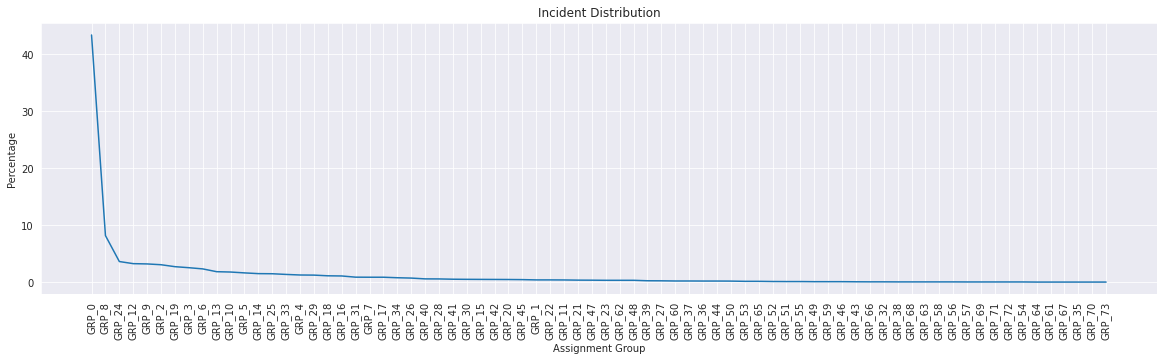

In [ ]:
sns.set_style("darkgrid")

## distibution based on Percentage
df_grp["count_perc"] = round((df_grp["counts"]/df.shape[0])*100,2)
df_grp.sort_values(["count_perc"], axis=0, ascending=False, inplace=True)

## View the Distribution of all Records
plt.subplots(figsize = (20,5))
plt.plot(df_grp["Assignment group"], df_grp["count_perc"])
plt.xlabel('Assignment Group')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.title('Incident Distribution')
plt.show()

As we see, majority of the tickets belong to GRP_0 followed by GRP_8, GRP_24, GRP_12, GRP_9 and rest to follow

### Lets analyse Short description & Description and find out if its enough to summarize the incident

In [ ]:
#Short description Analysis
print("Short description")
print("MAX str length          MIN str length ")
print(df['Short description'].str.len().max(), "                        ", df['Short description'].str.len().min() )

Short description
MAX str length          MIN str length 
159                          1


In [ ]:
#Description Analysis
print("Description")
print("MAX str length          MIN str length ")
print(df['Description'].str.len().max(), "                        ", df['Description'].str.len().min() )

Description
MAX str length          MIN str length 
13001                          1


We will combine the Short description & description and continue our similar analysis

In [ ]:
df["Combined Description"] = df["Short description"].map(str) + ' ' + df["Description"].map(str)
df.head()

Short description  ...                               Combined Description
0                    login issue  ...  login issue -verified user details.(employee# ...
1                        outlook  ...  outlook \r\n\r\nreceived from: hmjdrvpb.komuay...
2             cant log in to vpn  ...  cant log in to vpn \r\n\r\nreceived from: eylq...
3  unable to access hr_tool page  ...  unable to access hr_tool page unable to access...
4                   skype error   ...                          skype error  skype error 

[5 rows x 4 columns]

In [ ]:
#Combined Description Analysis
print("Combined Description")
print("MAX str length          MIN str length ")
print(df['Combined Description'].str.len().max(), "                        ", df['Combined Description'].str.len().min() )

Combined Description
MAX str length          MIN str length 
13104                          3


### Due to combining of columns, we can see that there are duplicate words in the new Combined description column. Hence we will delete the "duplicates words" in Combined Description column

In [ ]:
#Deleting the "duplicates words" in Combined Description column
df["Combined Description"] = df["Combined Description"].apply(lambda x: ' '.join(pd.unique(x.split())))
df.head()

Short description  ...                               Combined Description
0                    login issue  ...  login issue -verified user details.(employee# ...
1                        outlook  ...  outlook received from: hmjdrvpb.komuaywn@gmail...
2             cant log in to vpn  ...  cant log in to vpn received from: eylqgodm.ybq...
3  unable to access hr_tool page  ...                      unable to access hr_tool page
4                   skype error   ...                                        skype error

[5 rows x 4 columns]

In [ ]:
#Combined Description Analysis
print("Combined Description")
print("MAX str length          MIN str length ")
print(df['Combined Description'].str.len().max(), "                        ", df['Combined Description'].str.len().min() )

Combined Description
MAX str length          MIN str length 
8753                          1


####   Basis our initial analysis though we find that Short description with lesser string length captures and highlights the incident effectively, we have the same information passed on to Combined description.Using Description would be redundant efforts given that we have combined the Short description & Description columns. Hence, our preprocessing and model buidling would be intuitively based on Combined Description

## Visualizing different text features

Visualizing word cloud for Short description

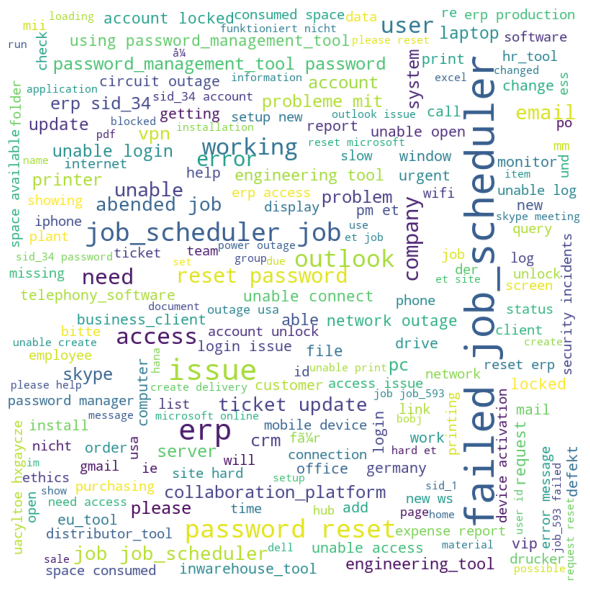

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['Short description']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Visualizing word cloud for Combined Description

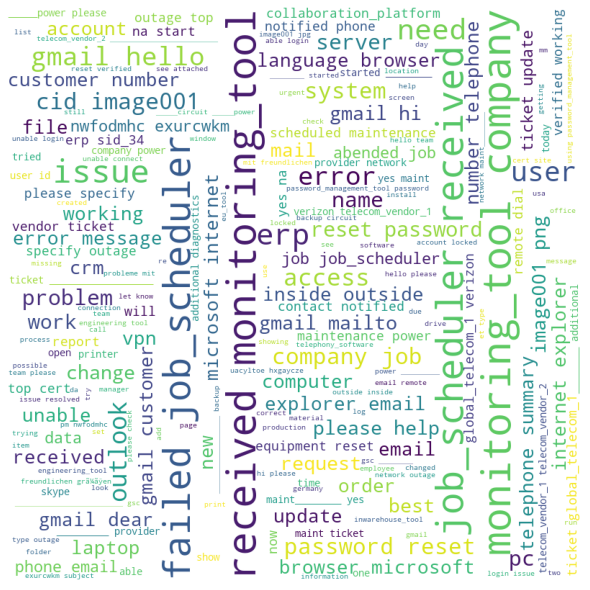

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['Combined Description']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

##### Looking at the words clouds of both "Short Description" and "Combined Description", it is evident that 'frequently used words' are higher in the latter than the former. Intuitively, we can understand that "Combined Description" will help a lot in this classification problem due to the larger number of 'frequently used words' and rich word vocabulary.

### Bi-Gram Frequency for Text - "Short Description"

In [ ]:

word_vectorizer = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix = word_vectorizer.fit_transform(df["Short description"])
frequencies = sum(sparse_matrix).toarray()[0]
bi_grams_df = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

In [ ]:
bi_grams_df.sort_values(by = "frequency",ascending=False).head(20)

frequency
in job_scheduler        937
failed in               785
job_scheduler at        785
unable to               600
at 09                   309
at 10                   298
password reset          272
not working             252
is not                  201
is down                 182
at 08                   173
et on                   162
down since              156
job in                  152
ticket update           148
abended job             147
access to               137
erp sid_34              129
to login                128
login to                120

### Bi Grams Data Visualization for "Short Description"

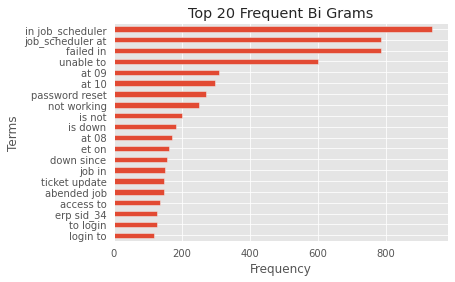

In [ ]:
plt.style.use("ggplot")
plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_bigrams = bi_grams_df["frequency"].sort_values(ascending = False).head(20)

top20_bigrams.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Bi Grams")

### Bi-Gram Frequency for Text - "Combined Description"

In [ ]:
word_vectorizer_c = CountVectorizer(ngram_range=(2,2), analyzer='word')
sparse_matrix_c = word_vectorizer_c.fit_transform(df["Combined Description"])
frequencies_c = sum(sparse_matrix_c).toarray()[0]
bi_grams_df_c = pd.DataFrame(frequencies_c, index=word_vectorizer_c.get_feature_names(), columns=['frequency'])

In [ ]:
bi_grams_df_c.sort_values(by = "frequency",ascending=False).head(20)

frequency
received from                 2226
gmail com                     2095
company com                   1317
in job_scheduler               944
from monitoring_tool           939
monitoring_tool company        939
job_scheduler at               790
failed in                      790
00 received                    783
unable to                      719
com hello                      392
at 08                          327
yes no                         320
at 09                          313
is not                         311
cid image001                   305
at 10                          301
not working                    298
password reset                 275
com mailto                     249

### Bi Grams Data Visualization for "Combined Description"

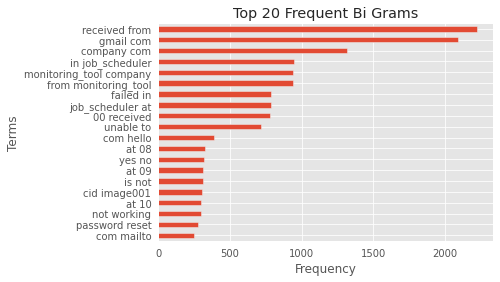

In [ ]:
plt.style.use("ggplot")
plt.xlabel("Frequency",)
plt.ylabel("Terms")
top20_bigrams_c = bi_grams_df_c["frequency"].sort_values(ascending = False).head(20)

top20_bigrams_c.head(20).sort_values(ascending = True).plot(kind="barh",title = "Top 20 Frequent Bi Grams")

#### When we look at the visualizations of top 20 Bi-grams, frequency of Bi-grams generated in "Combined Description" is significantly higher than of Short Description. Again it depicts that Combined Description has an edge over short description for better training and prediction. Also the information from Short desription has been carried over to Combined description to prevent any possible data loss

### Let's look at the MOST USED WORDS in "Short Description"

In [ ]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)

  # visualize words and frequencies
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()
  return d
# print 100 most frequent words


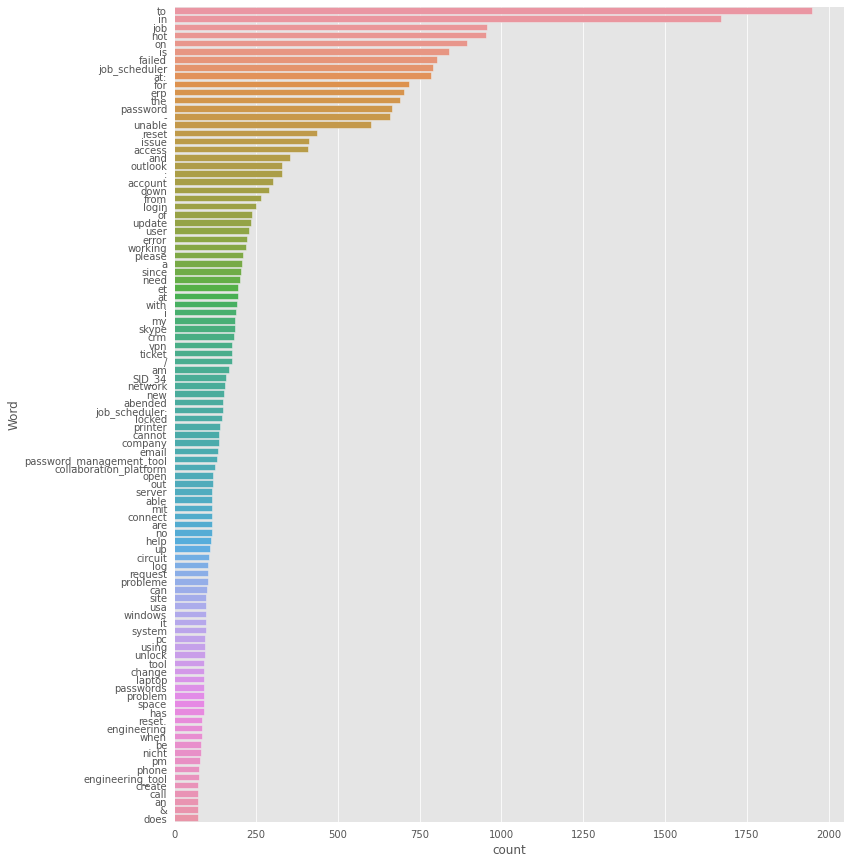

In [ ]:
d = freq_words(df['Short description'], 100)

### Let's check out the MOST USED WORDS in "Combined Description" as well

In [ ]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)

  # visualize words and frequencies
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  ax.set(ylabel = 'Word')
  plt.show()
  return d
# print 100 most frequent words

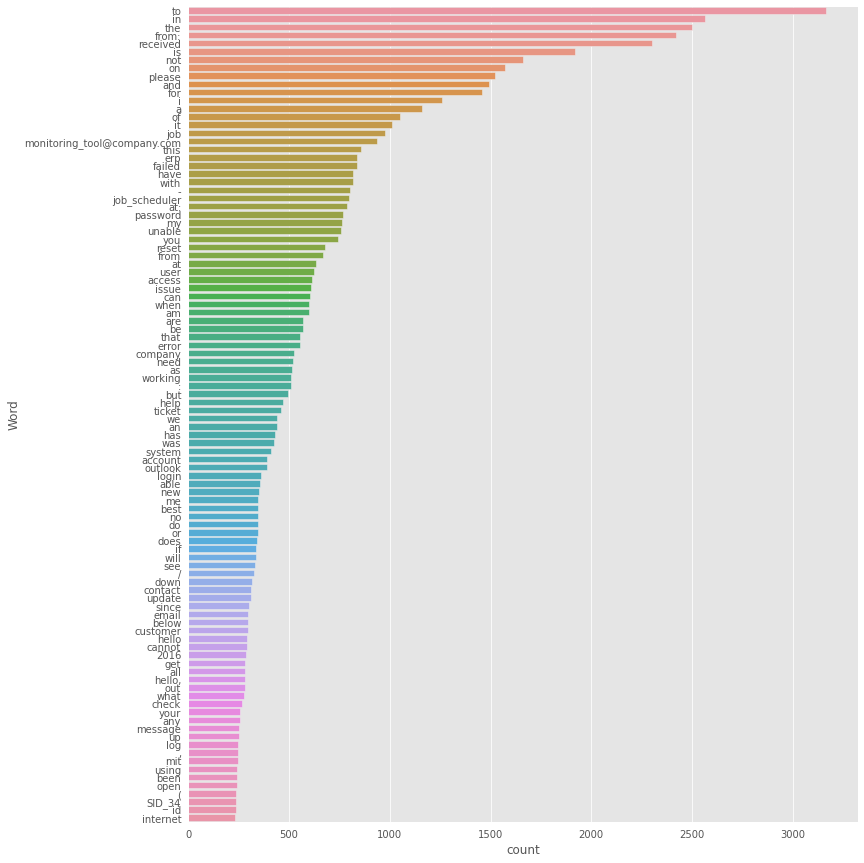

In [ ]:
d = freq_words(df['Combined Description'], 100)

##### When we look at the most used words distribution across Short and Combined Descriptions, one can notice that there are some similar words. Also there are many unique words in Short Description. On the Contrary, the Combined Description has lot of verbs, articles, adjectives etc.
##### This shows how pretext processing is essential before we can build the models and especially extensive processing is required for Combined Description.

## **Text preprocessing, Creating word vocabulary from the corpus of report text data and Creating tokens as required**

#### In a NLP project we need to pre-process the data to get it all in a consistent format.We need to clean, tokenize and convert our data into a matrix. Let's create a function which will perform the following tasks on the text columns:

1. Make text lowercase,
2. removes hyperlinks,
3. remove punctuation
4. removes numbers
5. tokenizes
6. removes stopwords
7. Disclaimer statements
8. Text Translation to English

### Translaton to English text using googletrans

In [ ]:
!pip install googletrans

     |████████████████████████████████| 61kB 3.5MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 942kB 22.8MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
     |████████████████████████████████| 61kB 9.8MB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp36-none-any.whl size=15736 sha256=ef66a3c4c8ca35a614d6e03c78f5ac5e6dd98fd936dd302a7032e3079d4211ab
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=e08c36b81a92fbd4613411d4cd82f6b3cc3e07d0d1afdfa48144f1f75aa4134c
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built googletrans contextvars


In [ ]:
# spanish to english
from googletrans import Translator
translator = Translator()
df["Combined Description"].apply(translator.translate, src='es', dest='en').apply(getattr, args=('text',))

0       login issue -verified user details. (employee ...
1       outlook received from: hmjdrvpb.komuaywn@gmail...
2       cant log in to vpn received from: eylqgodm.ybq...
3                           unable to access hr_tool page
4                                             skype error
                              ...                        
8495    emails not coming in from zz mail received fro...
8496                             telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
8498    machine is not working i am unable to access t...
8499    an mehreren pc`s lassen sich verschiedene prgr...
Name: Combined Description, Length: 7903, dtype: object

In [ ]:
# german to english
from googletrans import Translator
translator = Translator()
df["Combined Description"].apply(translator.translate, src='de', dest='en').apply(getattr, args=('text',))

0       login issue -verified user details. (employee ...
1       outlook received from: hmjdrvpb.komuaywn@gmail...
2       cant log in to vpn received from: eylqgodm.ybq...
3                           unable to access hr_tool page
4                                             skype error
                              ...                        
8495    emails not coming in from zz mail received fro...
8496                             telephony_software issue
8497    vip2: windows password reset for tifpdchb pedx...
8498    machine nÃ£o estÃ¡ funcionando i am unable to ...
8499    Different programs cannot be opened on several...
Name: Combined Description, Length: 7903, dtype: object

### Using nltk for removing stop words, converting nltk tag to wordnet tag & lemmatization

In [ ]:
from contextlib import redirect_stdout
with redirect_stdout(open(os.devnull, "w")):             ### Silence download progressing by re-directing to stdout
   nltk.download('stopwords')
   nltk.download('punkt')
   nltk.download('averaged_perceptron_tagger')
   nltk.download('wordnet')
   from nltk.corpus import stopwords

In [ ]:
stop = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()

In [ ]:
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
#lemmatization
def lemmatize_sentence(sentence):

    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))

    #tuple of (token, wordnet_tag)

    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# function to identify & remove unwanted characters from text in "Combined Description"
temp =[]
for sentence in df["Combined Description"]:
    sentence = sentence.lower() #lower case
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
    sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
    sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
    sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp.append(words)
    #print ("Sentence = ",sentence)

In [ ]:
#storing the transformed text
df["Combined Description"] = temp

In [ ]:
# function to identify & remove unwanted characters from text in "Short description"
temp =[]
for sentence in df["Short description"]:
    sentence = sentence.lower() #lower case
    cleanr = re.compile('<.*?>')
    sentence = re.sub(cleanr, ' ', sentence)        #removing HTML tags
    sentence = re.sub(r'\S+@\S+', 'EmailId', sentence)#removing mail ids
    sentence = re.sub(r'\S+@\S+', 'https', sentence)#removing https
    sentence = re.sub(r'\S+@\S+', 'http', sentence)#removing http
    sentence = re.sub(r'\'', '', sentence, re.I|re.A)
    sentence = re.sub(r'[0-9]', '', sentence, re.I|re.A)
    sentence = re.sub(r'[^a-zA-Z0-9\s]', ' ', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'com ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'Subject: ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'\[cid:(.*)]', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'hello ', ' ', sentence, re.I|re.A)
    sentence = re.sub(r'The information(.*)infection', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'Endava Limited is a company(.*)or omissions', ' ', sentence,  re.I|re.A)  # footer
    sentence = re.sub(r'The information in this email is confidential and may be legally(.*)interference if you are not the intended recipient', ' ', sentence, re.I|re.A)  # footer
    sentence = re.sub(r'select the following link to view the disclaimer in an alternate language.', ' ', sentence, re.I|re.A)  # disclaimer footer
    l_sentence = lemmatize_sentence(sentence)

    words = [word for word in l_sentence.split() if word not in stopwords.words('english')]
    temp.append(words)
    #print ("Sentence = ",sentence)

In [ ]:
#storing the transformed text
df["Short description"] = temp

In [ ]:
#Additional text cleaning - We noticed that several rows still have junk characters that will have to be removed
df = df[df['Combined Description'].map(lambda d: len(d)) > 0]
df = df[df['Short description'].map(lambda d: len(d)) > 0]

#join the words list back
df['Combined Description']=[" ".join(description) for description in df['Combined Description'].values]
df['Short description']=[" ".join(description) for description in df['Short description'].values]

In [ ]:
# saving the transformed text
df.to_csv("trans_text.csv")

## Visualizing post Text processing & Cleaning

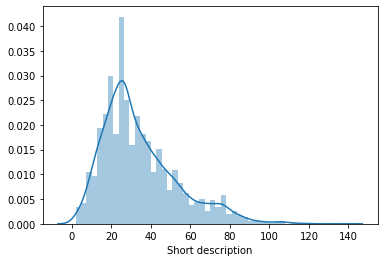

In [ ]:
sns.distplot(df['Short description'].str.len())

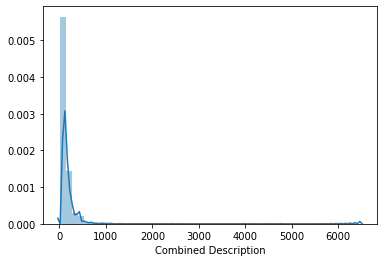

In [ ]:
sns.distplot(df['Combined Description'].str.len())

We have different strings of varying lengths, using Pad sequences would be a better option later while building a DNN model

## Word Cloud Visualization

### Word Cloud Visualization for "Short description"

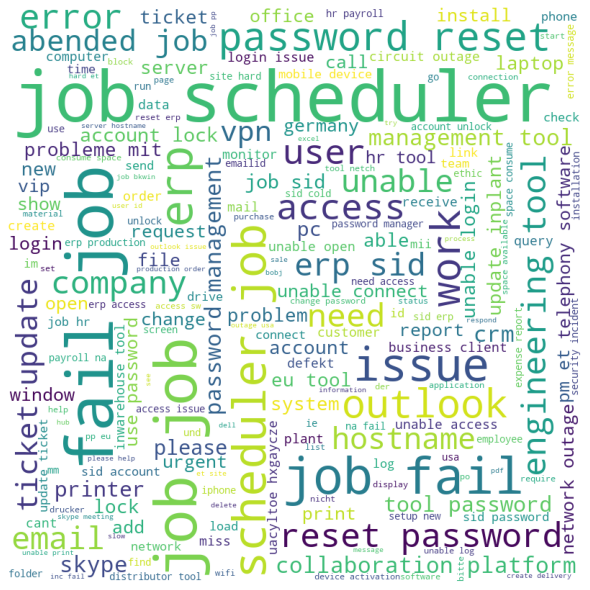

In [ ]:
# Python program to generate WordCloud

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['Short description']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

### Word Cloud Visualization for "Combined Description"

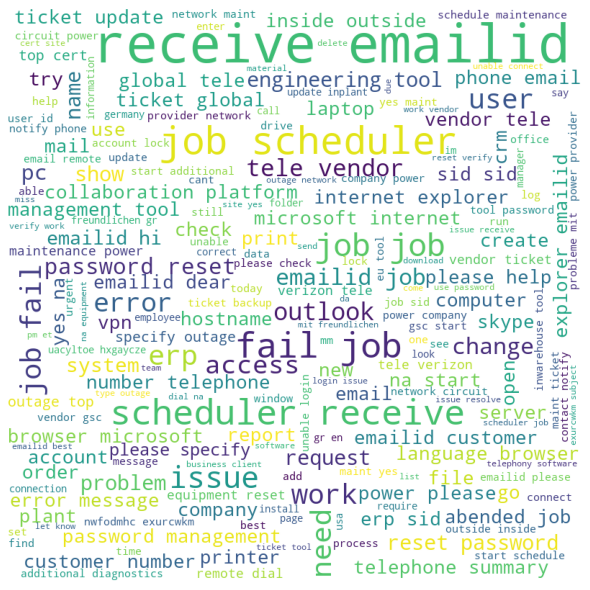

In [ ]:
comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['Combined Description']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

In [ ]:
## create a column to mark records with GRP_0 and non GRP_0=>GRP_X
df['GRP_MOD'] = df['Assignment group'].apply(lambda x: 'GRP_X' if x != 'GRP_0' else x)

In [ ]:
## function to create Word Cloud
def show_wordcloud(data, title):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

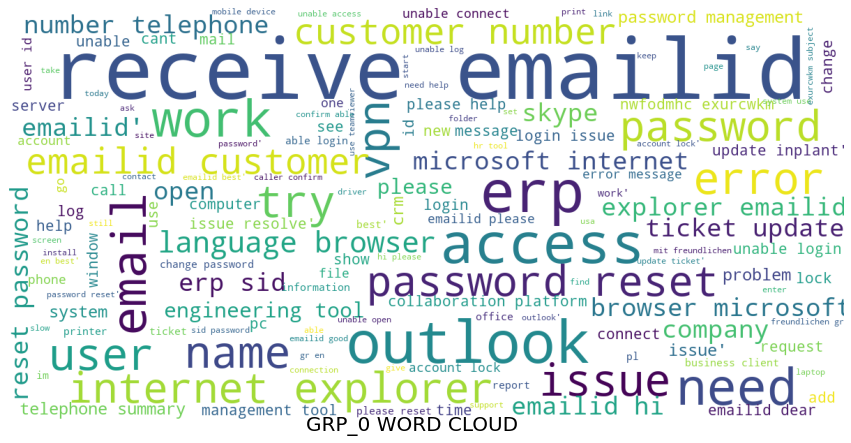

In [ ]:
## view word cloud for GRP_0
text_Str = df['Combined Description'][df['GRP_MOD'].isin(["GRP_0"])].tolist()
show_wordcloud(text_Str, "GRP_0 WORD CLOUD")

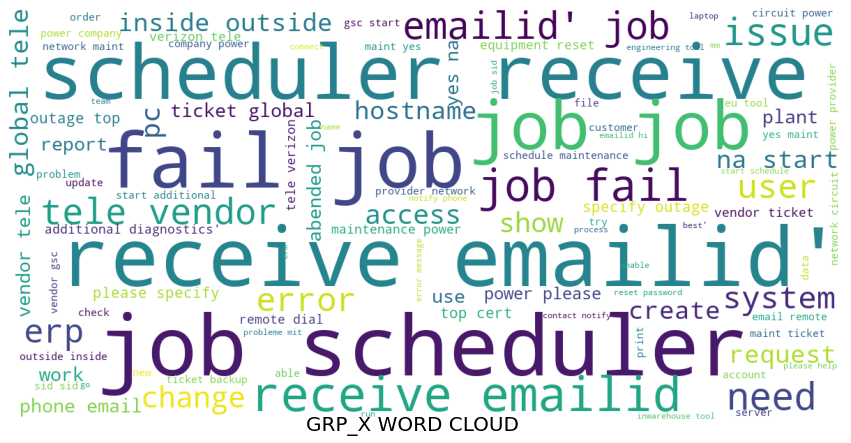

In [ ]:
## GRP_X Visualization:
text_Str = df['Combined Description'][df['GRP_MOD'].isin(["GRP_X"])].tolist()
show_wordcloud(text_Str, "GRP_X WORD CLOUD")

### Word Clouds for Groups that have higher incidents other than GRP_0

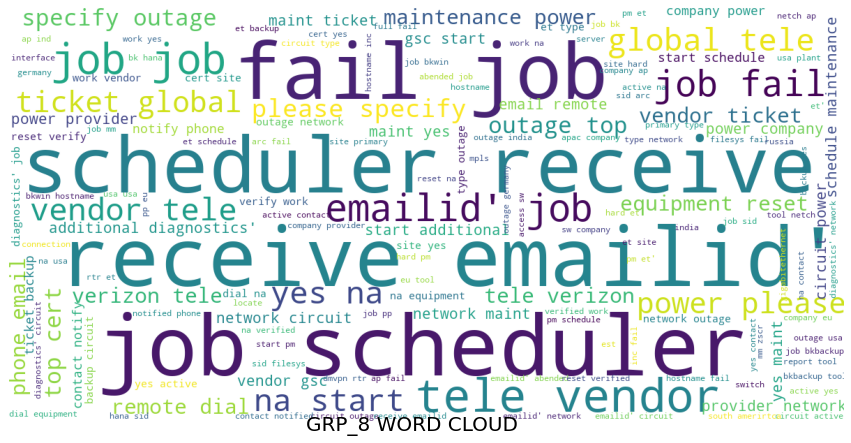

In [ ]:
#GRP_8
text_Str1 = df['Combined Description'][df['Assignment group'].isin(["GRP_8"])].tolist()
show_wordcloud(text_Str1,"GRP_8 WORD CLOUD" )

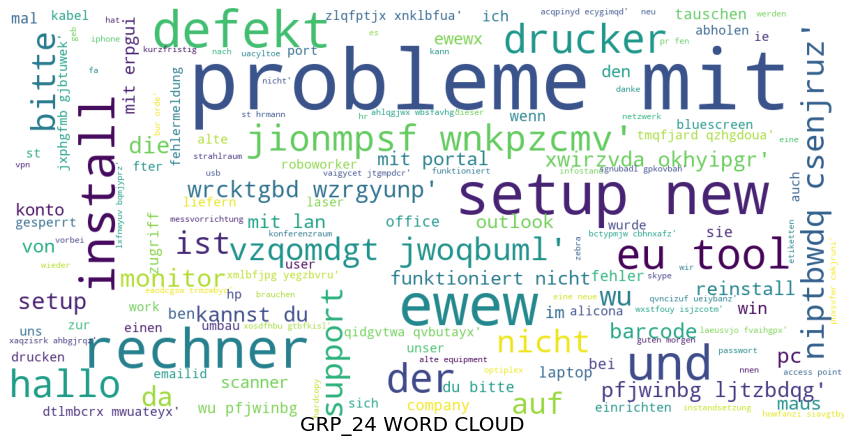

In [ ]:
#GRP_24
text_Str1 = df['Combined Description'][df['Assignment group'].isin(["GRP_24"])].tolist()
show_wordcloud(text_Str1,"GRP_24 WORD CLOUD" )

## Setting up Paramaters for Multinomial Naive Bayes Model

In [ ]:
column_to_predict = "Assignment group"
text_columns = "Combined Description"
classifier = "NB"  # Supported algorithms # "SVM" # "NB"
use_grid_search = True  # grid search is used to find hyperparameters. Searching for hyperparameters is time consuming
remove_stop_words = True  # removes stop words from processed text
stop_words_lang = 'english'  # used with 'remove_stop_words' and defines language of stop words collection
use_stemming = False  # word stemming using nltk
fit_prior = True  # if use_stemming == True then it should be set to False ?? double check
min_data_per_class = 1  # used to determine number of samples required for each class.Classes with less than that will be excluded from the dataset. default value is 1


### Prepare data and labels and split them to train and test sets


In [ ]:
data = df[text_columns]
labelData = df[column_to_predict]

# Split dataset into training and testing data
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labelData, test_size=0.2
)  # split data to train/test sets with 80:20 ratio

In [ ]:
print (len(train_data), len(test_data), len(train_labels), len(test_labels))

6283 1571 6283 1571


### Extracting features from text using CountVectorizer and TF-IDF transformer

In [ ]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        stemmer = SnowballStemmer("english", ignore_stopwords=True)
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
# Count vectorizer
if remove_stop_words:
    count_vect = CountVectorizer(stop_words=stop_words_lang)
elif use_stemming:
    count_vect = StemmedCountVectorizer(stop_words=stop_words_lang)
else:
    count_vect = CountVectorizer()

vectorized_data = count_vect.fit_transform(train_data)
vectorized_data.shape

(6283, 12892)

In [ ]:
tfidf = TfidfTransformer()
features = tfidf.fit_transform(vectorized_data)
features.shape

(6283, 12892)


### Using pipeline to preprocess data and train classifier

In [ ]:
# Fitting the training data into a data processing pipeline and eventually into the model itself
if classifier == "NB":
    print("Training NB classifier")
    # Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
    # The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
    # We will be using the 'text_clf' going forward.

    text_clf = Pipeline([
        ('vect', count_vect),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB(fit_prior=fit_prior))
    ])
    text_clf = text_clf.fit(train_data, train_labels)

Training NB classifier


### Use GridSearchCV to search for best set of parameters

In [ ]:
if use_grid_search:
    # Grid Search
    # Here, we are creating a list of parameters for which we would like to do performance tuning.
    # All the parameters name start with the classifier name (remember the arbitrary name we gave).
    # E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

    # NB parameters
    parameters = {
        'vect__ngram_range': [(1, 1), (2, 2)],
        'tfidf__use_idf': (True, False),
        'clf__alpha': (1e-2, 1e-3)
    }

    # Next, we create an instance of the grid search by passing the classifier, parameters
    # and n_jobs=-1 which tells to use multiple cores from user machine.
    gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
    gs_clf = gs_clf.fit(train_data, train_labels)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [ ]:
# To see the best mean score
gs_clf.best_score_

0.6447552305813559

In [ ]:
# To see the best parm
gs_clf.best_params_

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

## Evaluate the model

In [ ]:
print("Evaluating model")
# Score and evaluate model on test data using model without hyperparameter tuning
predicted = text_clf.predict(test_data)
prediction_acc = np.mean(predicted == test_labels)
print("Confusion matrix without GridSearch:")
print(metrics.confusion_matrix(test_labels, predicted))
print("Mean without GridSearch: " + str(prediction_acc))

Evaluating model
Confusion matrix without GridSearch:
[[711   0   0 ...   0   0   0]
 [  4   0   0 ...   0   2   0]
 [ 15   0   0 ...   0  15   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  6   0   0 ...   0 117   0]
 [ 11   0   0 ...   0  43   0]]
Mean without GridSearch: 0.5448758752387015


In [ ]:
# Score and evaluate model on test data using model WITH hyperparameter tuning
if use_grid_search:
    predicted = gs_clf.predict(test_data)
    prediction_acc = np.mean(predicted == test_labels)
    print("Confusion matrix with GridSearch:")
    print(metrics.confusion_matrix(test_labels, predicted))
    print("Mean with GridSearch: " + str(prediction_acc))

Confusion matrix with GridSearch:
[[655   0   0 ...   0   0   0]
 [  3   1   0 ...   0   2   0]
 [  8   0  11 ...   0   7   0]
 ...
 [  1   0   0 ...   0   0   0]
 [  3   0   0 ...   0 104   0]
 [  6   0   0 ...   0  36   9]]
Mean with GridSearch: 0.6327180140038192


### Ploting confusion matrix

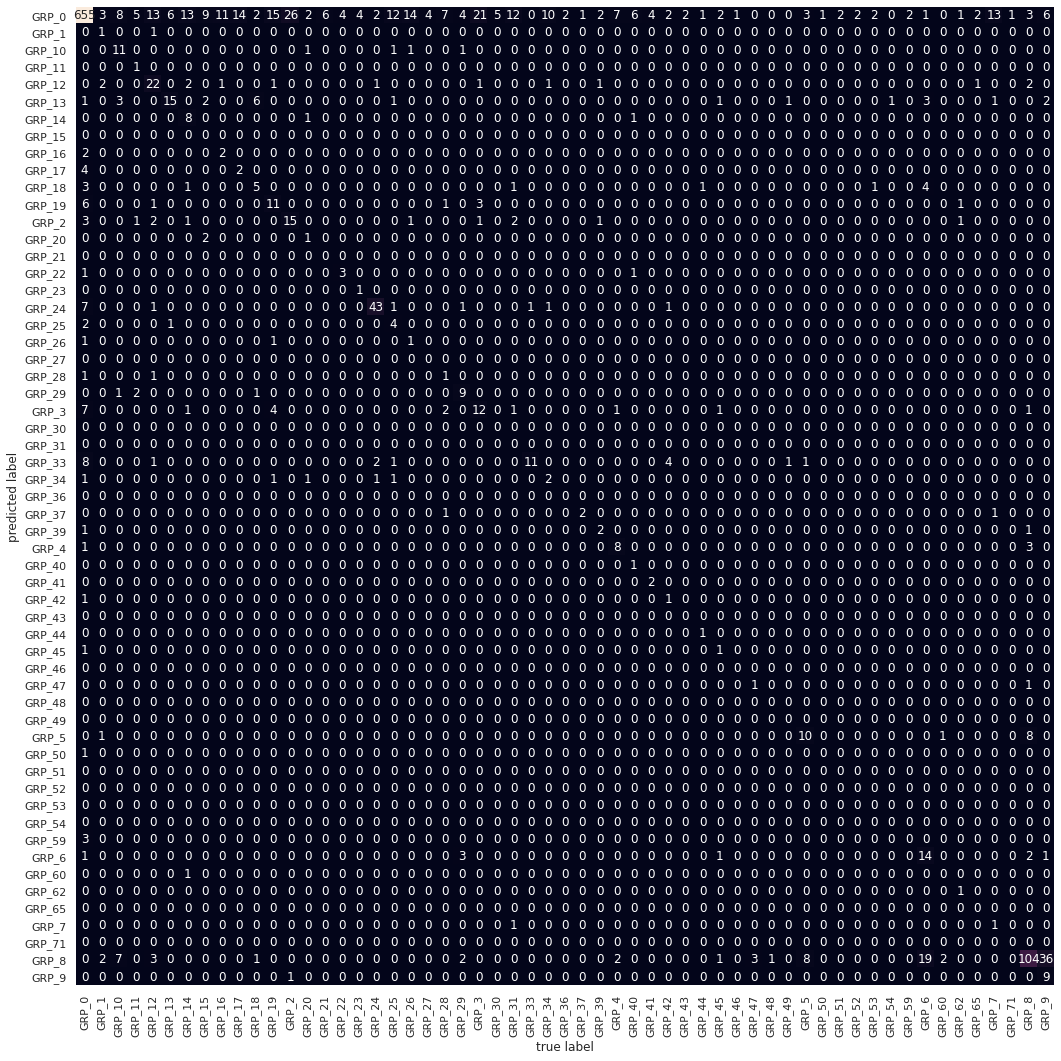

In [ ]:
# Ploting confusion matrix with 'seaborn' module
# Use below line only with Jupyter Notebook

mat = confusion_matrix(test_labels, predicted)
plt.figure(figsize=(18, 18))
sns.set()
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

## Printing classification report for Multinomial Naive Bayes

In [ ]:
%matplotlib inline
print(classification_report(test_labels, predicted,
                            target_names=np.unique(test_labels)))

              precision    recall  f1-score   support

       GRP_0       0.69      0.92      0.79       711
       GRP_1       0.50      0.11      0.18         9
      GRP_10       0.73      0.37      0.49        30
      GRP_11       1.00      0.11      0.20         9
      GRP_12       0.63      0.49      0.55        45
      GRP_13       0.41      0.68      0.51        22
      GRP_14       0.80      0.30      0.43        27
      GRP_15       0.00      0.00      0.00        13
      GRP_16       0.50      0.14      0.22        14
      GRP_17       0.33      0.12      0.18        16
      GRP_18       0.31      0.33      0.32        15
      GRP_19       0.48      0.33      0.39        33
       GRP_2       0.54      0.36      0.43        42
      GRP_20       0.33      0.17      0.22         6
      GRP_21       0.00      0.00      0.00         6
      GRP_22       0.60      0.43      0.50         7
      GRP_23       1.00      0.20      0.33         5
      GRP_24       0.77    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




## Multinomial Naive Bayes Metrics Summary


The F1 score, precision and recall scores are higher for predicting GRP_0 than any other group, as we know from EDA that GRP_0 has 47% of total datapoints.

GRP_8 and GRP_24 has good scores as well following GRP_0, as they have relatively higher data points than groups.



## Model Building with Deep Learning Approach - LSTM

### Vocabulary of words and Label Encoding

In [ ]:
all_words = list()
for w in df['Combined Description']:
    all_words.append(w)

In [ ]:
print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 6655


In [ ]:
index_dict = dict()
count = 1
index_dict['<unk>'] = 0
for word in set(all_words):
    index_dict[word] = count
    count += 1

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(df["Assignment group"])

## Tokenizer & Pad sequences

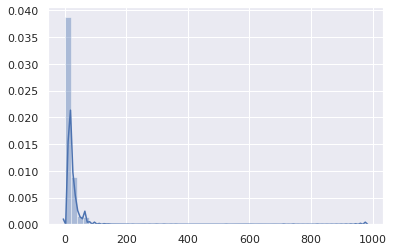

In [ ]:
vocab_size = 6655  # There are 6655 words in total
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['Combined Description'])

train_inputs = tokenizer.texts_to_sequences(df['Combined Description'])
sns.distplot([len(l) for l in train_inputs])

Set the max len of vector to 50, since most incidents contain no more than 50 words

## Set the parameters

In [ ]:
maxlen = 50

In [ ]:
X = tokenizer.texts_to_sequences(df['Combined Description'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(df['Assignment group'])

print("Number of Samples:", len(X))
print(X[0])
print("Number of Labels: ", len(y))
print(y[0])

Number of Samples: 7854
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0  41   7 203  10 109 159  83
  28  46  28 304  16   5 186  46 423 192  59  41   7 110]
Number of Labels:  7854
GRP_0


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(6675, 50) (6675,)
(1179, 50) (1179,)


In [ ]:
Embedding(6655, 32, input_length=50)

## Create the model

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = maxlen))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0))
model.add(Dense(74,activation='softmax'))
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 128)           851840    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 74)                14578     
Total params: 1,121,218
Trainable params: 1,121,218
Non-trainable params: 0
_________________________________________________________________
None


## Fit the model

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
209/209 - 2s - loss: 2.5056 - accuracy: 0.4731 - val_loss: 2.1912 - val_accuracy: 0.5055
Epoch 2/10
209/209 - 2s - loss: 1.9904 - accuracy: 0.5368 - val_loss: 2.0566 - val_accuracy: 0.5411
Epoch 3/10
209/209 - 2s - loss: 1.7683 - accuracy: 0.5648 - val_loss: 1.9025 - val_accuracy: 0.5445
Epoch 4/10
209/209 - 2s - loss: 1.5941 - accuracy: 0.5951 - val_loss: 1.8331 - val_accuracy: 0.5606
Epoch 5/10
209/209 - 2s - loss: 1.4444 - accuracy: 0.6213 - val_loss: 1.7685 - val_accuracy: 0.5598
Epoch 6/10
209/209 - 2s - loss: 1.3122 - accuracy: 0.6437 - val_loss: 1.7946 - val_accuracy: 0.5827
Epoch 7/10
209/209 - 2s - loss: 1.2172 - accuracy: 0.6661 - val_loss: 1.7267 - val_accuracy: 0.5835
Epoch 8/10
209/209 - 2s - loss: 1.1073 - accuracy: 0.6954 - val_loss: 1.7764 - val_accuracy: 0.5835
Epoch 9/10
209/209 - 2s - loss: 1.0647 - accuracy: 0.7013 - val_loss: 1.7395 - val_accuracy: 0.5649
Epoch 10/10
209/209 - 2s - loss: 0.9759 - accuracy: 0.7236 - val_loss: 1.7402 - val_accuracy: 0.5929

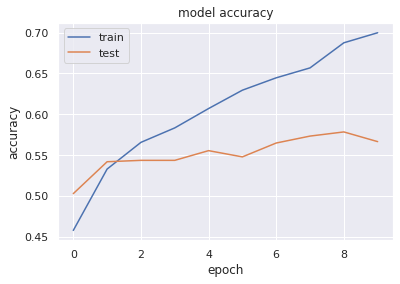

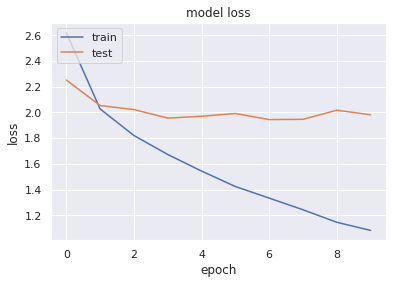

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# predict probabilities for test set
Y_pred = model.predict(X_test, verbose=0)

## Let's peek at the final classification report in terms of metrics such as Precision, Recall, F1-Score and Support for the LSTM Model

In [ ]:
print(metrics.classification_report (Y_test, np.argmax(Y_pred, axis = 1),zero_division=1,target_names=np.unique(encoder.inverse_transform(Y_test))))

              precision    recall  f1-score   support

       GRP_0       0.72      0.90      0.80       505
       GRP_1       1.00      0.11      0.20         9
      GRP_10       0.24      0.29      0.26        17
      GRP_11       0.00      0.00      0.00         8
      GRP_12       0.65      0.59      0.62        51
      GRP_13       0.29      0.35      0.32        20
      GRP_14       0.20      0.15      0.17        20
      GRP_15       0.08      0.25      0.12         4
      GRP_16       0.25      0.08      0.12        13
      GRP_17       0.91      0.83      0.87        12
      GRP_18       0.43      0.18      0.25        17
      GRP_19       0.20      0.17      0.18        47
       GRP_2       0.59      0.32      0.42        31
      GRP_20       0.00      0.00      0.00         6
      GRP_21       1.00      0.00      0.00         7
      GRP_22       1.00      0.00      0.00         4
      GRP_23       1.00      0.00      0.00         1
      GRP_24       0.90    

## LSTM Metrics Summary


The F1 score, precision and recall scores are higher for predicting GRP_0 than any other group, as we know from EDA that GRP_0 has 47% of total datapoints. GRP_8 and GRP_24 has good scores as well following GRP_0.

But very interestingly, GRP_17 has scored top of the table with highest F1 and other scores with just 12 data points. (This was not the case with traditional Naive Bayes model)




## **Results Dashboard**

## Model Test Accuracy Summary

1.   Multinomial Naive Bayes  -  63 %
2.   Vanilla LSTM (DNN)       -  59 %

## F1 Report Summary

1.   Multinomial Naive Bayes  -  58 %
2.   Vanilla LSTM (DNN)       -  54 %

---


##**Conclusion** (Milestone 1)

Multi-label text classification is one of the most common text classification problems. In this exercise, we studied

1.   One traditional Machine Learning model using Multinomial Naive Bayes with & without Grid search and
2.   A deep learning approach using LSTM for multi-label text classification.

Comparatively Multinomial Naive Bayes with Grid search has an slight edge over the Vanilla LSTM neural network in this classification problem. However these are just the base models.  

Looking at the accuracy & their F1 scores, we might have the opportunity to improve upon them to have the classes predicted more effectively.

##**Next Steps**

As next steps,

1) We would be changing the hyper parameters within these models so as to improve the accuracy and being able to predict the class outputs better.

2) Also we will try to explore more deep neural networks and state of art models like BERT & ULMfit

3) Since the dataset is highly imbalanced, We will try to downsample GRP_0 datapoints and upsample other Groups to generate a well-balanced dataset.

4) Also, there are texts in non english language that we will work upon to translate to english in our next iteration as part of preprocessing.

# Milestone 2

## Bi-directional LSTM -   Lets us build and train a bi-LSTM model and see how our classification looks

In [ ]:
# load file
clean_text = pd.read_csv('trans_text.csv')
clean_text = clean_text.drop(columns=['Unnamed: 0','Short description','Description'], axis = 1)

In [ ]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
Y = encoder.fit_transform(clean_text["Assignment group"])

In [ ]:
from keras.utils import to_categorical
Y = to_categorical(Y)

In [ ]:
all_words = list()
for w in clean_text['Combined Description']:
    all_words.append(w)

print('Size of vocabulary: {}'.format(len(set(all_words))))

Size of vocabulary: 6655


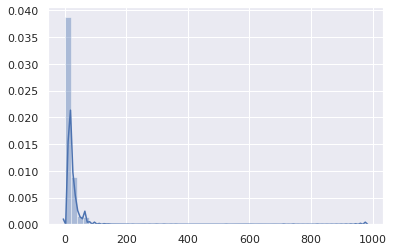

In [ ]:
vocab_size = 6655
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(clean_text['Combined Description'])
train_inputs = tokenizer.texts_to_sequences(clean_text['Combined Description'])
sns.distplot([len(l) for l in train_inputs])

### Set the parameters

In [ ]:
vocab_size = 6655
maxlen = 50

In [ ]:
X = tokenizer.texts_to_sequences(clean_text['Combined Description'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(clean_text['Assignment group'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print((X_train.shape),(Y_train.shape))
print((X_test.shape),(Y_test.shape))

(6675, 50) (6675, 74)
(1179, 50) (1179, 74)


In [ ]:
Embedding(vocab_size, 32, input_length=maxlen)

## **BIDIRECTIONAL LSTM LAYER**

In [ ]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(vocab_size, embed_dim,input_length = maxlen))
model.add(SpatialDropout1D(0.4))
model.add(Bidirectional(LSTM(10, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(74,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 50, 128)           851840    
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 50, 128)           0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 50, 20)            11120     
_________________________________________________________________
bidirectional_30 (Bidirectio (None, 100)               28400     
_________________________________________________________________
dense_18 (Dense)             (None, 74)                7474      
Total params: 898,834
Trainable params: 898,834
Non-trainable params: 0
_________________________________________________________________
None


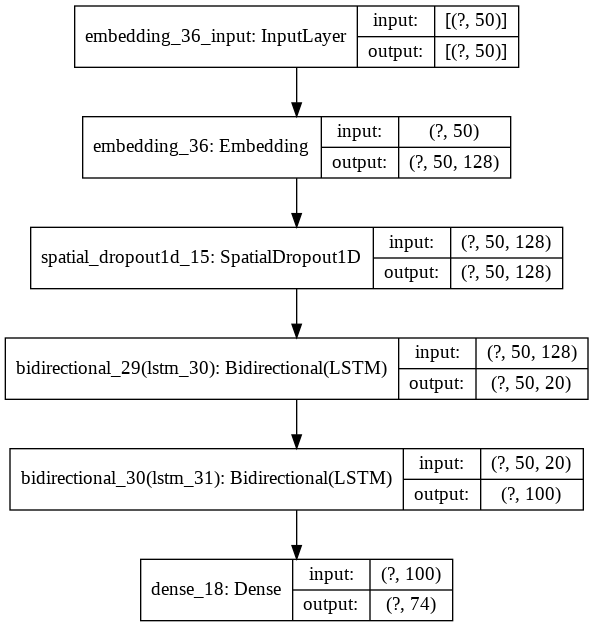

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
batch_size = 32
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs = 10, batch_size=batch_size, verbose = 2)

Epoch 1/10
209/209 - 5s - loss: 2.6196 - accuracy: 0.4629 - val_loss: 2.2560 - val_accuracy: 0.5021
Epoch 2/10
209/209 - 4s - loss: 2.0340 - accuracy: 0.5252 - val_loss: 2.0418 - val_accuracy: 0.5394
Epoch 3/10
209/209 - 3s - loss: 1.8064 - accuracy: 0.5604 - val_loss: 1.9726 - val_accuracy: 0.5420
Epoch 4/10
209/209 - 3s - loss: 1.6251 - accuracy: 0.5849 - val_loss: 1.9028 - val_accuracy: 0.5581
Epoch 5/10
209/209 - 3s - loss: 1.4722 - accuracy: 0.6168 - val_loss: 1.9037 - val_accuracy: 0.5640
Epoch 6/10
209/209 - 3s - loss: 1.3356 - accuracy: 0.6449 - val_loss: 1.9329 - val_accuracy: 0.5674
Epoch 7/10
209/209 - 3s - loss: 1.2331 - accuracy: 0.6646 - val_loss: 1.9198 - val_accuracy: 0.5683
Epoch 8/10
209/209 - 4s - loss: 1.1424 - accuracy: 0.6858 - val_loss: 1.9556 - val_accuracy: 0.5547
Epoch 9/10
209/209 - 3s - loss: 1.0766 - accuracy: 0.7028 - val_loss: 1.9995 - val_accuracy: 0.5615
Epoch 10/10
209/209 - 3s - loss: 1.0122 - accuracy: 0.7215 - val_loss: 1.9716 - val_accuracy: 0.5606

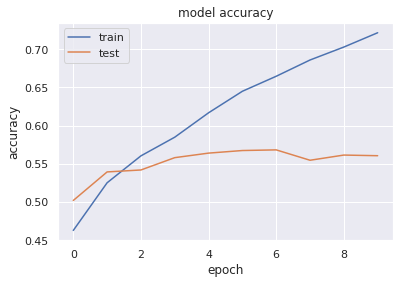

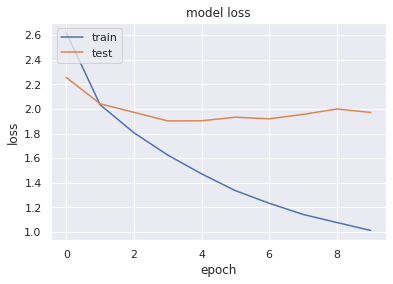

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
# predict probabilities for test set
Y_pred = model.predict(X_test)
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       505
           1       0.00      0.00      0.00         9
           2       0.25      0.29      0.27        17
           3       0.00      0.00      0.00         8
           4       0.56      0.39      0.46        51
           5       0.24      0.35      0.29        20
           6       0.08      0.10      0.09        20
           7       0.00      0.00      0.00         4
           8       0.05      0.08      0.06        13
           9       0.86      1.00      0.92        12
          10       0.00      0.00      0.00        17
          11       0.21      0.15      0.17        47
          12       0.22      0.32      0.26        31
          13       0.00      0.00      0.00         6
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         1
 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### With Bidrectional LSTM, we get a validation accuracy of 56% and F1 score of 53%. Lets try some state of art models like BERT & ULMfit to see if the classification is being done better

## State of the Art Model 1 - **BERT**

### Let’s set up the environment.

In [ ]:
!pip install -q transformers --quiet

### Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path

import os

import torch
import torch.optim as optim

import random

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

#### The current versions of the fastai and transformers libraries are respectively 1.0.61 and 3.0.2.

In [ ]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 3.0.2


### Original Data

In [ ]:
# load file
clean_text = pd.read_csv('trans_text.csv')

### Extracting the required features for modelling

In [ ]:
clean_text = clean_text.drop(columns=['Unnamed: 0','Short description','Description'], axis = 1)
clean_text.head()

Assignment group                               Combined Description
0            GRP_0  login issue verify user detail employee manage...
1            GRP_0  outlook receive emailid team meeting skype mee...
2            GRP_0               cant log vpn receive emailid hi best
3            GRP_0                         unable access hr tool page
4            GRP_0                                        skype error

### Function to split Train and Test sets

In [ ]:
def split_train_valid_test(data,valid_ratio,test_ratio):
    shuffled_indcies=np.random.permutation(len(data))
    valid_set_size= int(len(data)*valid_ratio)
    valid_indcies=shuffled_indcies[:valid_set_size]
    test_set_size= int(len(data)*test_ratio)
    test_indcies=shuffled_indcies[valid_set_size:test_set_size+valid_set_size]
    train_indices=shuffled_indcies[test_set_size:]
    return data.iloc[train_indices],data.iloc[valid_indcies],data.iloc[test_indcies]

train_set,valid_set,test_set=split_train_valid_test(clean_text,valid_ratio=0.2,test_ratio=0.2)

In [ ]:
print(len(train_set),len(test_set))  # Counts of Train and Test Sets

6284 1570


In [ ]:
train_set.head()

Assignment group                               Combined Description
7078            GRP_0                               ticket update ticket
4657            GRP_0                  question login impact award award
432             GRP_2  employee account reactivation etdh thsydaass e...
6000            GRP_8     job sid arc fail job scheduler receive emailid
6307            GRP_9         job job fail job scheduler receive emailid

In [ ]:
test_set.head()

Assignment group                               Combined Description
7078            GRP_0                               ticket update ticket
4657            GRP_0                  question login impact award award
432             GRP_2  employee account reactivation etdh thsydaass e...
6000            GRP_8     job sid arc fail job scheduler receive emailid
6307            GRP_9         job job fail job scheduler receive emailid

### Time to get the data ready for Transformer models

In [ ]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig)
}

### Setting up the parms

In [ ]:
# Parameters
seed = 42
use_fp16 = False
bs = 8

#model_type = 'roberta'
#pretrained_model_name = 'roberta-base'

model_type = 'bert'
pretrained_model_name='bert-base-uncased'

# model_type = 'distilbert'
# pretrained_model_name = 'distilbert-base-uncased'

#model_type = 'xlm'
#pretrained_model_name = 'xlm-clm-enfr-1024'

# model_type = 'xlnet'
# pretrained_model_name = 'xlnet-base-cased'

Assigning required classes for transformer model architechture

In [ ]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

### Print the available values for pretrained_model_name corresponding to the model_type used.

In [ ]:
print(model_class) # Since we are passing Roberta model in the paramters, we can see model_class has assumed Roberta model type

<class 'transformers.modeling_bert.BertForSequenceClassification'>


### Function to set the seed for generating random numbers

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [ ]:
## Calling the seed_all function

seed_all(seed)

#### Defining a Class for Custom Tokenization to inherit from base tokenizer as there are lot of classes wrapped in each other.

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


#### Tokenizing from the pre-trained model

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

### Custom Numericalizer
In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object.

So, we are creating a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

It consists of using the functions convert_tokens_to_ids and convert_ids_to_tokens in respectively numericalize and textify

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer

    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)

    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

#### The functions __gestate__ and __setstate__ allow the functions export and load_learner to work correctly with TransformersVocab.

### Custom processor
Now that we have our custom tokenizer and numericalizer, we can create the custom processor.

We are passing the include_bos = False and include_eos = False options. This is because fastai adds its own special tokens by default which interferes with the [CLS] and [SEP] tokens added by our custom tokenizer.

In [ ]:

transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

### Setting up the Databunch

As mentioned in the HuggingFace documentation, BERT, RoBERTa, XLM and DistilBERT are models with absolute position embeddings, so it's usually advised to pad the inputs on the right rather than the left. Regarding XLNET, it is a model with relative position embeddings, therefore, you can either pad the inputs on the right or on the left.

In [ ]:
pad_first = bool(model_type in ['bert'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']
[16183, 4904, 1039, 9765, 25175, 1010, 7592, 2009, 1055, 2033]


['sal', '##ut', 'c', 'est', 'moi', ',', 'hello', 'it', 's', 'me']

There is multible ways to create a DataBunch, in our implementation, we use the data block API, which gives more flexibility.

In [ ]:
databunch = (TextList.from_df(train_set, cols = 'Combined Description', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols = 'Assignment group')
             .add_test(test_set)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
GRP_73, GRP_69
  if getattr(ds, 'warn', False): warn(ds.warn)


#### Check batch and tokenizer :

In [ ]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()


[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : [PAD]


#### Check batch and numericalizer

In [ ]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)

[CLS] id : 101
[SEP] id : 102
[PAD] id : 0
Batch shape :  torch.Size([8, 512])
tensor([[  101,  3036,  5043,  ..., 19627,  2581,   102],
        [  101,  3036,  5043,  ...,  2546,  1020,   102],
        [    0,     0,     0,  ...,  6585,  2653,   102],
        ...,
        [    0,     0,     0,  ..., 21426,  3669,   102],
        [    0,     0,     0,  ...,  7542,  4722,   102],
        [    0,     0,     0,  ...,  3619,  3967,   102]])


### Custom model

While Migrating from pytorch-pretrained-bert to transformers, every model's forward method always outputs a "tuple" with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [ ]:
# defining our model architecture
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model

    def forward(self, input_ids, attention_mask=None):

        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type())

        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]
        return logits

#### To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels.

In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 74
config.use_bfloat16 = use_fp16
print(config)

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABEL_34",
    "35": "LABEL_35",
 

### Setting the configuration to the model

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 74)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Learner : Custom Optimizer / Custom Metric

In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. For reproducing BertAdam specific behavior, we are setting correct_bias = False.

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = None
gc.collect()

learner = Learner(databunch,
                  custom_transformer_model,
                  opt_func = CustomAdamW,
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

### Discriminative Fine-tuning and Gradual unfreezing

To use discriminative layer training and gradual unfreezing, fastai provides one tool that allows to "split" the structure model into groups.

Unfortunately, the model architectures are too different to create a unique generic function that can "split" all the model types in a convenient way. Thereby, we are going to implement a custom "split".

In our case, if we use the RobBERTa model and that we observe his architecture by making print(learner.model).

In [ ]:
print(learner.model)

CustomTransformerModel(
  (transformer): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feature

#### We can decide to divide the model in 14 blocks :

  * 1 Embedding

  * 12 transformer

  * 1 classifier

In this case, we can split our model in this way :

In [ ]:
# For bert-base
list_layers = [learner.model.transformer.bert.embeddings,
              learner.model.transformer.bert.encoder.layer[0],
              learner.model.transformer.bert.encoder.layer[1],
              learner.model.transformer.bert.encoder.layer[2],
              learner.model.transformer.bert.encoder.layer[3],
              learner.model.transformer.bert.encoder.layer[4],
              learner.model.transformer.bert.encoder.layer[5],
              learner.model.transformer.bert.encoder.layer[6],
              learner.model.transformer.bert.encoder.layer[7],
              learner.model.transformer.bert.encoder.layer[8],
              learner.model.transformer.bert.encoder.layer[9],
              learner.model.transformer.bert.encoder.layer[10],
              learner.model.transformer.bert.encoder.layer[11],
              learner.model.transformer.bert.pooler]

### Check groups :

In [ ]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

### Train the Model

Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.

In [ ]:
learner.save('untrain')

In [ ]:
seed_all(seed)
learner.load('untrain');

#### Therefore, we first freeze all the groups but the classifier with :

In [ ]:
learner.freeze_to(-1)

### We check which layer are trainable.

In [ ]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [512, 768]           23,440,896 False     
______________________________________________________________________
Embedding            [512, 768]           393,216    False     
______________________________________________________________________
Embedding            [512, 768]           1,536      False     
______________________________________________________________________
LayerNorm            [512, 768]           1,536      False     
______________________________________________________________________
Dropout              [512, 768]           0          False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
______________________________________________________________________
Linear               [512, 768]           590,592    False     
_______________________________________

### For Slanted Triangular Learning Rates we need to use the function one_cycle. For more information please check the fastai documentation here.

#### To use our one_cycle we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using lr_find.

In [ ]:
learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-04
Min loss divided by 10: 1.00E-04


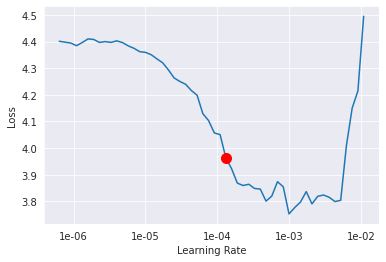

In [ ]:
learner.recorder.plot(skip_end=10,suggestion=True)

#### We will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-4 seems to be a good value.

#### Next we will use fit_one_cycle with the chosen learning rate as the maximum learning rate.

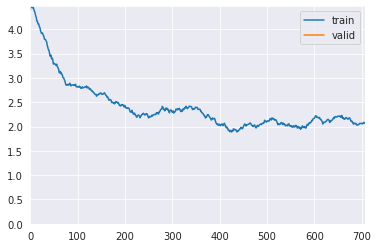

In [ ]:
learner.fit_one_cycle(1,max_lr=2e-04,moms=(0.8,0.7))

In [ ]:
learner.save('first_cycle')

In [ ]:
seed_all(seed)
learner.load('first_cycle');

#### We then unfreeze the second group of layers and repeat the operations.

In [ ]:
learner.freeze_to(-2)

In [ ]:
lr = 1e-5

#### Here that we use slice to create separate learning rate for each group.

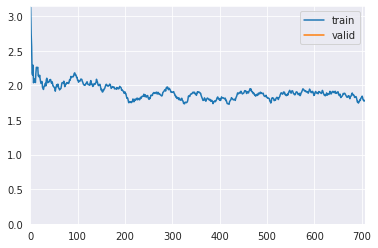

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('second_cycle')

In [ ]:
seed_all(seed)
learner.load('second_cycle');

In [ ]:
learner.freeze_to(-3)

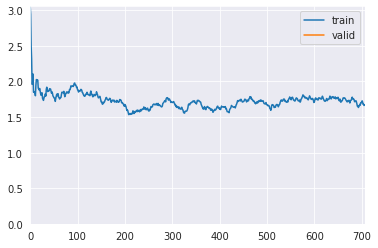

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('third_cycle')

In [ ]:
seed_all(seed)
learner.load('third_cycle');

In [ ]:
learner.freeze_to(-4)

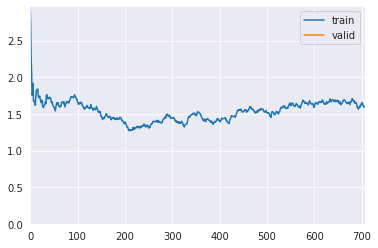

In [ ]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [ ]:
learner.save('fourth_cycle')

In [ ]:
seed_all(seed)
learner.load('fourth_cycle');

### Here, we unfreeze all the groups.

In [ ]:
learner.unfreeze()

### First we will Train for 5 epochs

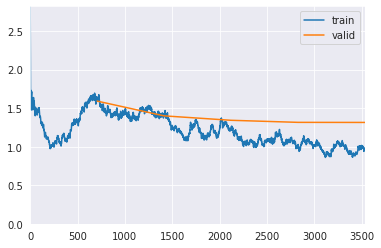

In [ ]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

### Now we will Train for Another 5 epochs

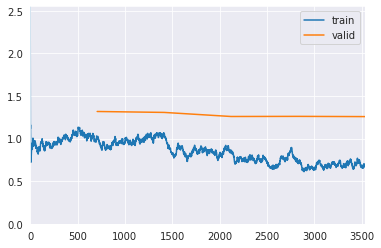

In [ ]:
learner.fit_one_cycle(5, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

### Now Let's see the results, later we can do individual description-wise prediction

In [ ]:
learner.show_results(10)

In [ ]:
pred_val = learner.get_preds(DatasetType.Valid)

In [ ]:
pred_val_l = pred_val[0].argmax(1)

In [ ]:
print(classification_report(pred_val[1], pred_val_l))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       272
           1       0.00      0.00      0.00         4
           2       0.62      0.50      0.56        10
           4       0.54      0.75      0.63        20
           5       0.23      1.00      0.37         5
           6       0.67      0.38      0.48        16
           7       0.00      0.00      0.00         3
           8       0.50      0.50      0.50         6
           9       0.86      0.86      0.86         7
          10       0.40      0.33      0.36         6
          11       0.60      0.35      0.44        17
          12       0.50      0.47      0.48        17
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         4
          17       0.79      1.00      0.88        19
          18       0.78    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### With BERT, post Hyper-parameter tuning we get an accuracy of 69% and F1 score of 65%

## State of the Art Model 2 - **ULMFIT**

In [ ]:
# import libraries
import fastai
from fastai.text import *
from fastai.callbacks import *

In [ ]:
# load file
train = pd.read_csv('trans_text.csv')



In [ ]:
train = train.drop(columns=['Unnamed: 0','Short description','Description'], axis = 1)
train.head()

Assignment group                               Combined Description
0            GRP_0  login issue verify user detail employee manage...
1            GRP_0  outlook receive emailid team meeting skype mee...
2            GRP_0               cant log vpn receive emailid hi best
3            GRP_0                         unable access hr tool page
4            GRP_0                                        skype error

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train)

Load Language model data, and Finetune Language model

In [ ]:
# Language model data : We use test_df as validation for language model
data_lm = TextLMDataBunch.from_df(path = "",train_df= train ,valid_df = val)

In [ ]:
#save the preprocessed data
data_lm.save()

In [ ]:
# Classifier model data
data_clas  = TextClasDataBunch.from_df('.', train_df=train,text_cols='Combined Description',label_cols='Assignment group',valid_df=val,vocab=data_lm.train_ds.vocab)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
GRP_61, GRP_67
  if getattr(ds, 'warn', False): warn(ds.warn)


In [ ]:
# save the data class
data_clas.save()

In [ ]:
data_clas.show_batch()



https://docs.fast.ai/text.transform.html#BaseTokenizer

The rules are all listed below, here is the meaning of the special tokens:

UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)

PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch

BOS (xxbos) represents the beginning of a text in your dataset

FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)

TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text

TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})

TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})


### Language model data : We use val as validation for language model

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

### Find the optimal Learning rate using find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 1.10E-01


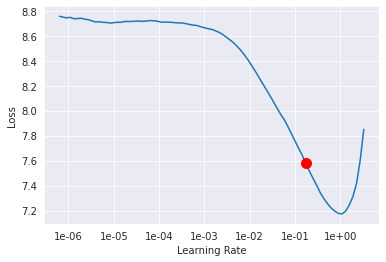

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Learning With Discriminative fine tuninig

In [ ]:
learn.fit_one_cycle(2, 7.5E-02,callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8,0.7))
learn.save('fit_head')
learn.unfreeze()

Better model found at epoch 0 with valid_loss value: 4.381277561187744.
Better model found at epoch 1 with valid_loss value: 4.007747650146484.


### Find the optimal Learning rate using find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 8.32E-06
Min loss divided by 10: 7.59E-04


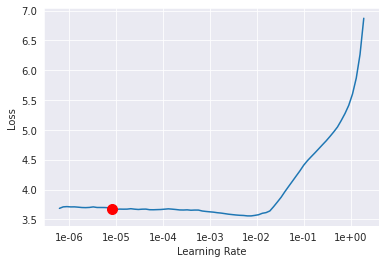

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(3,3.5E-04,callbacks=[SaveModelCallback(learn, name="best_lm")], moms=(0.8,0.7))

Better model found at epoch 0 with valid_loss value: 3.9429397583007812.
Better model found at epoch 1 with valid_loss value: 3.892089366912842.


In [ ]:
learn.load('best_lm')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5890 items)
x: LMTextList
xxbos password expire,xxbos erp account lock,xxbos job hr xxunk fail job scheduler receive emailid,xxbos issue bex business client receive emailid dear sir madam able access bex well business client pl rectify immediately urgent,xxbos abended job job scheduler bk hana sid erp dly dp receive emailid
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (1964 items)
x: LMTextList
xxbos job job fail job scheduler receive emailid,xxbos issue symantec endpoint protection warn message icon xxunk please see attached document show message,xxbos install ki ewew xxunk xxunk,xxbos password reset request password management tool password,xxbos circuit outage india carrier company ap ind carrier dmvpn rtr et site secondary type network x circuit power please specify outage top cert yes na start schedule maintenance power company power provider network maint yes maint ticket backup yes active yes contact notify phone email r

In [ ]:
learn.save_encoder('AIBoot_enc')

### Buliding the Text Classifier

In [ ]:
learn1 = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn1.load_encoder('AIBoot_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5890 items)
x: TextList
xxbos password expire,xxbos erp account lock,xxbos job hr xxunk fail job scheduler receive emailid,xxbos issue bex business client receive emailid dear sir madam able access bex well business client pl rectify immediately urgent,xxbos abended job job scheduler bk hana sid erp dly dp receive emailid
y: CategoryList
GRP_0,GRP_0,GRP_5,GRP_0,GRP_8
Path: .;

Valid: LabelList (1962 items)
x: TextList
xxbos job job fail job scheduler receive emailid,xxbos issue symantec endpoint protection warn message icon xxunk please see attached document show message,xxbos install ki ewew xxunk xxunk,xxbos password reset request password management tool password,xxbos circuit outage india carrier company ap ind carrier dmvpn rtr et site secondary type network x circuit power please specify outage top cert yes na start schedule maintenance power company power provider network maint yes maint ticket backup yes active yes contact n

### Hyperparameter Tuning - Find the optimal Learning rate using find()

In [ ]:
learn1.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 4.79E-02
Min loss divided by 10: 1.45E-02


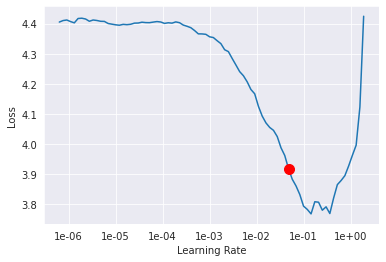

In [ ]:
learn1.recorder.plot(suggestion=True)

In [ ]:
best_clf_lr = learn1.recorder.min_grad_lr
best_clf_lr

0.0478630092322638

In [ ]:
# Fitting Classifier Object
learn1.fit_one_cycle(1, best_clf_lr)

### Finetune Base Language Model Layers + Task Specific Layers on Task Specific Data

In [ ]:
# Fitting Classifier Object after freezing all but last 2 layers
learn1.freeze_to(-2)

In [ ]:
# Fitting Classifier Object
learn1.fit_one_cycle(1, best_clf_lr)

In [ ]:
learn1.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 2.29E-07


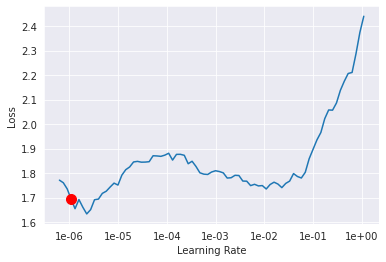

In [ ]:
learn1.lr_find()
learn1.recorder.plot(suggestion=True)

### Hyperparameter Tuning - Lets use a learning rate of 2e-3

In [ ]:
learn1.fit_one_cycle(10, 2.2e-3)

In [ ]:
learn1.show_results(10)

In [ ]:
pred_val = learn1.get_preds(DatasetType.Valid, ordered=True)

In [ ]:
pred_val_l = pred_val[0].argmax(1)

In [ ]:
print(classification_report(pred_val[1], pred_val_l))

              precision    recall  f1-score   support

           0       0.76      0.93      0.83       843
           1       1.00      0.27      0.43        11
           2       0.64      0.45      0.53        31
           3       0.50      0.17      0.25        12
           4       0.66      0.53      0.58        76
           5       0.53      0.60      0.56        35
           6       0.56      0.44      0.49        34
           7       0.43      0.38      0.40         8
           8       0.56      0.26      0.36        19
           9       0.94      1.00      0.97        15
          10       0.42      0.42      0.42        26
          11       0.59      0.30      0.40        66
          12       0.55      0.42      0.48        62
          13       0.00      0.00      0.00        10
          14       0.40      0.17      0.24        12
          15       0.42      0.50      0.45        10
          16       0.33      1.00      0.50         2
          17       0.94    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### With ulmfit, post Hyper-parameter tuning we get an accuracy of 68% and F1 score of 65%

# **Results**

We built models ranging from basic ones (MNB, vanilla LSTM) to the state of art models to observe how the classification is being done.

Interestingly and as expected, the state of art models like BERT & ULMFIT does classify better over the simple models given the complexicity of their architecture versus their ease of use. Below table captures the accuracy & F1 score of each model.

In [ ]:
results = pd.read_excel('results.xlsx')
results

Model  ...  F1 Score (weighted avg.)
0  Multinomial Naïve Bayes (with Grid search CV)  ...                      0.58
1                                           LSTM  ...                      0.54
2                             Bidirectional LSTM  ...                      0.53
3               BERT (with best hyperparameters)  ...                      0.65
4             ULMFIT (with best hyperparameters)  ...                      0.65

[5 rows x 3 columns]

#**Conclusion** (Milestone 2)

In continuation to Milestone 1, we were able to build & train

1.   BidirectionalLSTM model
2.   Bidirectional Encoder Representations from Transformers (BERT)
3.   Universal Language Model Fine-tuning (ULMFiT)

We saw that BERT & ULMfit perform better on the task of classification compared over the other models

In a massively fruitful journey aimed at understanding various
procedures related to Natural Language Processing, we covered the
myriad techniques of data exploration, preprocessing and model
building. We recognized the importance of getting acquainted with
the data before performing and preprocessing or model building
procedures. Moreover, we understood the significance of change in
textual data that preprocessing brings about and why it affects the
model building stage.
To have a foundation to work upon, a couple of rudimentary models
were then built, and the performances were notes as a base for further
improvement. Different performance metrics were employed and the
one most suitable for the dataset in question was chosen.

# **Next Steps**

In the course of our journey, there were several ideas and trials that
didn’t materialize into the final notebook. We found, however, that
even these failed attempts taught us a lot, and many of them could
possibly be worked upon in the future.

1) Divide the problem into two models
After observing the dataset, an initial idea was to split the problem into
two parts. The first challenge would be to successfully classify between
group 0 and other groups (since the data imbalance often led to all
predictions resulting in group 0). The next and the more challenging
step would be to feed all the datapoints which were predicted to NOT
be in group 0 by the first model, into a second model that classifies
further into all the other groups.This model, however, proved to be a failure as the first model tended to easily overfit. This approach, however, might prove useful in the future for similar datasets.

2) Topic Modelling
In machine learning and natural language processing, a topic model
is a type of statistical model for discovering the abstract "topics" that
occur in a collection of documents. It identifies recurring patterns in
the text. This method, however, was too complex for the application at
hand, but will be an interesting tool to experiment with in the future

3) Translation of non-english words
On finding that there were some non-english languages in the dataset,
we tried using various translation tools such as googletrans, and langid
to translate the text. Langid didn’t prove to be accurate enough, while
googletrans didn’t contribute significantly to the overall model
performance. Other libraries such as the hunspell library must be
touched upon in the future.

4) Oversampling
An attempt to use SMOTE oversampling was made, so as to overcome
the large imbalance in the data without losing out on and information.
This, however, resulted in two classes being deducted in the
oversampled dataset for unknown reasons. This dataset, hence, could
not be used as an input to the model.

5) Performance metrics
Though f1 score gives a decent idea of the model performance in the
current problem statement, it may be interesting to gain insights using
other performance metrics such as the AUC score and bleu metrics for
a more realistic inference.

6) K-fold cross validation
Cross validation is a method by which in every cycle, the data trains
and tests on a different subset of data.


